In [34]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
import string
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# dataset
from sklearn.datasets import fetch_20newsgroups

# loading train dataset
news_group_train = fetch_20newsgroups(subset='train')
news_group_data_train = news_group_train.data
news_group_target_names_train = news_group_train.target_names
news_group_target_train = news_group_train.target

# Creating a dataframe from the loaded data
news_train = pd.DataFrame({'news': news_group_data_train, 
                        'class': news_group_target_train})

#Loading test data
news_group_test = fetch_20newsgroups(subset='test')
news_group_data_test = news_group_test.data
news_group_target_names_test = news_group_test.target_names
news_group_target_test = news_group_test.target

# Creating a dataframe from the loaded data
news_test = pd.DataFrame({'news': news_group_data_test, 
                        'class': news_group_target_test})
#Merging both dataset
frames = [news_train,news_test]
news_df = pd.concat(frames).reset_index(drop=True)

print(news_df.shape)
news_df.head(1)

ModuleNotFoundError: No module named 'pyLDAvis.gensim_model'

In [2]:
#Removing Email
def remove_email(text):
    items = text.split()
    return " ".join([item for item in text.split() if '@' not in item])
news_df["news"] = news_df["news"].apply(lambda text: remove_email(text))
news_df.head(1)

,news,class
0,From: (where's my thing) Subject: WHAT car is ...,7


In [3]:
#Lowercasing
news_df["news"] = news_df["news"].str.lower()
news_df.head(1)

,news,class
0,from: (where's my thing) subject: what car is ...,7


In [4]:
#Stopword removal
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

news_df["news"] = news_df["news"].apply(lambda text: remove_stopwords(text))
news_df.head(1)

,news,class
0,from: (where's thing) subject: car this!? nntp...,7


In [5]:
#Removal of Punctuations
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

news_df["news"] = news_df["news"].apply(lambda text: remove_punctuation(text))
news_df.head(1)

,news,class
0,from wheres thing subject car this nntpposting...,7


In [6]:
# Convert to list
data = news_df["news"].values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

['from wheres thing subject car this nntppostinghost rac3wamumdedu organization university maryland college park lines 15 wondering anyone could enlighten car saw day 2door sports car looked late 60s early 70s called bricklin doors really small addition front bumper separate rest body know anyone tellme model name engine specs years production car made history whatever info funky looking car please email thanks il brought neighborhood lerxst ']


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'thing', 'subject', 'car', 'this', 'nntppostinghost', 'rac', 'wamumdedu', 'organization', 'university', 'maryland', 'college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'email', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']]


In [9]:
#Lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'subject', 'car', 'nntppostinghost', 'rac', 'wamumdedu', 'organization', 'university', 'maryland', 'college', 'park', 'line', 'wonder', 'enlighten', 'car', 'saw', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'email', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [10]:
# Create Dictionary
dictionary_LDA = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [dictionary_LDA.doc2bow(data_lemmatized) for data_lemmatized in data_lemmatized]
num_topics = 20
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary_LDA, passes=4, alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary_LDA.keys()))

# # View
# print(corpus[:1])

# # Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [11]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.042*"subject" + 0.042*"line" + 0.041*"organization" + 0.028*"university" + 0.020*"nntppostinghost" + 0.013*"thank" + 0.013*"email" + 0.013*"distribution" + 0.010*"know" + 0.009*"computer"

1: 0.017*"say" + 0.014*"god" + 0.010*"go" + 0.009*"know" + 0.009*"come" + 0.009*"see" + 0.007*"people" + 0.007*"man" + 0.007*"sin" + 0.006*"love"

2: 0.024*"game" + 0.013*"team" + 0.010*"player" + 0.010*"year" + 0.009*"play" + 0.009*"get" + 0.009*"go" + 0.009*"line" + 0.008*"win" + 0.008*"fan"

3: 0.011*"line" + 0.011*"car" + 0.011*"subject" + 0.010*"write" + 0.010*"organization" + 0.008*"engine" + 0.008*"use" + 0.008*"article" + 0.007*"know" + 0.006*"also"

4: 0.024*"homosexual" + 0.015*"man" + 0.014*"sex" + 0.013*"church" + 0.013*"homosexuality" + 0.013*"gay" + 0.011*"people" + 0.011*"write" + 0.009*"article" + 0.008*"study"

5: 0.024*"ms" + 0.020*"write" + 0.019*"myer" + 0.019*"line" + 0.016*"subject" + 0.015*"article" + 0.015*"organization" + 0.010*"re" + 0.010*"nntppostinghost" + 0.008*"jon

In [12]:
topics = [lda_model[corpus[i]] for i in range(len(data))]
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res
features=pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [15]:
#features=pd.concat([features,news_df['news']],axis=1).reset_index(drop=True)
features_df=pd.DataFrame(features)
features_df['news']=news_df['news']
features_df['class']=news_df['class']
features_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,news,class
0,0.148986,0.0,0.0,0.379388,0.0,0.122405,0.0,0.346266,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,from wheres thing subject car this nntpposting...,7


In [26]:
X_train, X_test, y_train, y_test = train_test_split(features_df[features_df.columns[0:-2]], features_df['class'], test_size=0.33, random_state=42,stratify=features_df['class'])

             0         1         2         3         4         5         6   \
8802   0.000000  0.000000  0.000000  0.000000  0.062307  0.000000  0.000000   
12565  0.230207  0.050905  0.000000  0.000000  0.369652  0.000000  0.079562   
6829   0.539473  0.000000  0.115003  0.000000  0.000000  0.000000  0.000000   
7599   0.000000  0.000000  0.000000  0.000000  0.137622  0.000000  0.000000   
1271   0.000000  0.000000  0.000000  0.000000  0.057161  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
7569   0.118459  0.000000  0.000000  0.000000  0.000000  0.198544  0.000000   
7131   0.000000  0.000000  0.130566  0.063816  0.000000  0.000000  0.000000   
5346   0.000000  0.309988  0.000000  0.000000  0.016109  0.000000  0.000000   
14387  0.236669  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9905   0.000000  0.000000  0.000000  0.000000  0.000000  0.442196  0.082520   

             7         8         9         10      

In [31]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(random_state=0,max_iter=20000).fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test,y_test)

0.569774919614148

In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary_LDA)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14     0.108340 -0.083747       1        1  9.098396
15     0.025988  0.126855       2        1  8.160231
16     0.096959  0.042661       3        1  7.780598
7      0.050137  0.074902       4        1  7.556473
12     0.102595 -0.129862       5        1  7.414549
0     -0.039153  0.190190       6        1  7.393053
1      0.088950 -0.118099       7        1  7.243091
2      0.012762  0.012552       8        1  6.688620
6      0.009504  0.180807       9        1  5.680518
13     0.047199 -0.010763      10        1  5.411105
18     0.090705 -0.082611      11        1  5.280228
11     0.026863 -0.225888      12        1  4.082121
9      0.025954  0.093778      13        1  4.024454
3      0.019138  0.090351      14        1  3.431215
17     0.026569 -0.061946      15        1  2.607958
19    -0.088621  0.045958      16        1  2.054521
4      0.044033 -0.144451      17        1  1.927820
5     -0.069684  0.085207      18        1  1.649718
10    -0.507622 -0.112444      19        1  1.380624
8     -0.070614  0.026551      20        1  1.134704, topic_info=              Term          Freq         Total Category  logprob  loglift
29    organization  20883.000000  20883.000000  Default  30.0000  30.0000
21            line  23753.000000  23753.000000  Default  29.0000  29.0000
41         subject  22693.000000  22693.000000  Default  28.0000  28.0000
407           file   5538.000000   5538.000000  Default  27.0000  27.0000
1664          game   4419.000000   4419.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
156            new    168.737847   6855.549402  Topic20  -5.1626   0.7743
553            now    148.934000   2264.600608  Topic20  -5.2874   1.7571
276            see    164.104977   9190.804307  Topic20  -5.1904   0.4533
2085           gun    146.507101   2155.938795  Topic20  -5.3039   1.7899
148              m    143.169948   7245.848413  Topic20  -5.3269   0.5546

[1510 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
6353       4  0.054086     aaron
6353       5  0.063101     aaron
6353       7  0.292968     aaron
6353      18  0.590444     aaron
614        1  0.890245  absolute
...      ...       ...       ...
13805     11  0.999365   zionist
22816      2  0.988416       zip
22816     20  0.010982       zip
8707      20  0.992503   zisfein
5289       9  0.997131   zoology

[5563 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 16, 17, 8, 13, 1, 2, 3, 7, 14, 19, 12, 10, 4, 18, 20, 5, 6, 11, 9])

In [39]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary_LDA)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

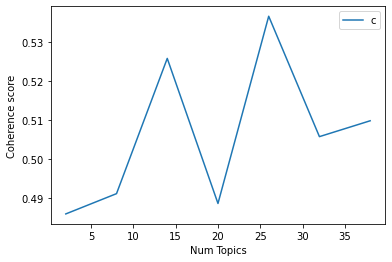

In [40]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_LDA, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [44]:
#Using no of topics=27
num_topics1 = 26
lda_model1 = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary_LDA, passes=4, alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary_LDA.keys()))
topics1 = [lda_model1[corpus[i]] for i in range(len(data))]
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics1))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res
features1=pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics1]) \
  .reset_index(drop=True).fillna(0)
features_df1=pd.DataFrame(features1)
features_df1['news']=news_df['news']
features_df1['class']=news_df['class']
features_df1.head(1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(features_df1[features_df1.columns[0:-2]], features_df1['class'], test_size=0.33, random_state=42,\
                                                        stratify=features_df1['class'])
from sklearn.linear_model import LogisticRegression
clf1=LogisticRegression(random_state=0,max_iter=20000).fit(X_train1, y_train1)
clf1.predict(X_test1)
clf1.score(X_test1,y_test1)
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(lda_model1, corpus, dictionary_LDA)
# vis

0.5660771704180064

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model1, corpus, dictionary_LDA)
vis

In [13]:
# lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=id2word, passes=2, workers=2)
# for idx, topic in lda_model.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))
# # Build LDA model
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)
# # Print the Keyword in the 10 topics
# print(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [14]:
# for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
#     print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [15]:
# def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row in enumerate(ldamodel[corpus]):
#         row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
#         # row = sorted(row, key=lambda x: (x[1]), reverse=True) # old line
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0: # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#     return(sent_topics_df)

In [16]:
# df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)
# #df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# # Show
# df_dominant_topic.head(10)


In [17]:
# df_dominant_topic=pd.concat([df_dominant_topic, news_df_train['class']], axis=1)
# # Show
# df_dominant_topic.head(10)